# Anchor Points

P2PNet distills the input image to a coarse grid of size **H/8 x W/8**, and then makes multiple predictions at these grid locations to compensate for the reduced spatial resolution. Rather than regressing absolute head positions directly, P2PNet predicts offsets relative to a set of predefined reference positions called **anchor points**. These anchors are defined in image coordinates, and the model learns to predict how far each anchor should move to reach a potential head location.

The figure below shows the anchor points overlaid on a sample image. Each 8x8 patch in the original image corresponds to a single location in the prediction grid. Within each patch, there are **N=4** anchor points (shown as red dots) evenly distributed. The model predicts offsets from these anchor points to the actual head positions, along with confidence scores for each prediction.

![Anchor Points](./pics/P2PNet-anchors.png)

## Anchors in image coordinates

To define the anchor points, we first need to determine the centers of each 8x8 patch in the original image. Given a prediction grid of size **H/S x W/S** derived from an input image of size **H x W**, the center of a patch located at grid position $(i, j)$ can be calculated as follows.

$$
\begin{aligned}
\text{center}_x &= \left(j + 0.5\right) \times S
\\
\text{center}_y &= \left(i + 0.5\right) \times S
\end{aligned}
$$

These coordinates are in the original image space, where the top-left corner is (0, 0) and the bottom-right corner is (W, H). The variables $i$ and $j$ correspond to the row and column indices of the downsampled grid, ranging from 0 to H/S - 1 and 0 to W/S - 1, respectively.

:::{warning}
**Watch out for the order of indices and coordinates!** The indices $(i, j)$ refer to the vertical position (row) and horizontal position (column) in the downsampled grid. The coordinates $(x, y)$ refer to the horizontal position (column) and vertical position (row) in the original image. Thus, in the equations above, $\text{center}_y$ is computed using $i$ (the row index), and $\text{center}_x$ is computed using $j$ (the column index).
:::

We can now specify the anchor points within each patch. For **N=4** anchors, we can place them at the following relative offsets from the patch center.

$$
\begin{aligned}
\text{anchor}_1 &= \left(\text{center}_x - \frac{S}{4}, \text{center}_y - \frac{S}{4}\right) \\
\text{anchor}_2 &= \left(\text{center}_x + \frac{S}{4}, \text{center}_y - \frac{S}{4}\right) \\
\text{anchor}_3 &= \left(\text{center}_x - \frac{S}{4}, \text{center}_y + \frac{S}{4}\right) \\
\text{anchor}_4 &= \left(\text{center}_x + \frac{S}{4}, \text{center}_y + \frac{S}{4}\right)
\end{aligned}
$$

The anchors can be precomputed and stored in a tensor of shape **(2, N, H/S, W/S)**. The first slice stores x-coordinates, the second slice stores y-coordinates. A simple implementation for the **N=4** case looks like this.

In [10]:
import torch

def make_anchors(height, width, stride=8, device="cpu"):
    Hf = height // stride
    Wf = width  // stride

    # Centers of each 8x8 patch
    ys = (torch.arange(Hf, device=device) + 0.5) * stride  # row centers
    xs = (torch.arange(Wf, device=device) + 0.5) * stride  # column centers
    grid_y, grid_x = torch.meshgrid(ys, xs, indexing="ij") # shape (Hf, Wf)

    # Adjust to get N=4 anchors per grid cell
    grid_x = grid_x.unsqueeze(0).repeat(4, 1, 1)  # shape (N, Hf, Wf)
    grid_y = grid_y.unsqueeze(0).repeat(4, 1, 1)  # shape (N, Hf, Wf)
    
    delta = stride // 4
    grid_x[[0, 2]] -= delta
    grid_x[[1, 3]] += delta
    grid_y[[0, 1]] -= delta
    grid_y[[2, 3]] += delta
    
    anchors = torch.stack([grid_x, grid_y], dim=0)  # shape (2, N, Hf, Wf)
    return anchors

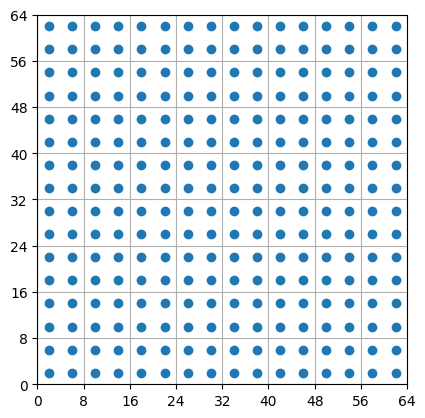

In [17]:
import matplotlib.pyplot as plt

H, W = 64, 64
S = 8
anchors = make_anchors(H, W, S)

plt.scatter(anchors[0].flatten(), anchors[1].flatten())
plt.gca().set_aspect("equal")
plt.xlim(0, W)
plt.ylim(0, H)
plt.xticks(range(0, W+1, S))
plt.yticks(range(0, H+1, S))
plt.grid()

## From offsets to head coordinates

The regression head of P2PNet predicts a tensor of shape (B, 2N, H/S, W/S), where B is the batch size. The first N channels contain the x-offsets for each anchor point, and the next N channels contain the corresponding y-offsets. To convert these offsets into pixel coordinates in the original image space, the predicted offsets are simply added to the anchor coordinates.

$$
\begin{aligned}
\text{predicted}_x &= \text{anchor}_x + \text{offset}_x \\
\text{predicted}_y &= \text{anchor}_y + \text{offset}_y
\end{aligned}
$$

The offsets can be scaled by a positive factor during training to control the range of predicted movements. This scaling helps stabilize training by preventing excessively large or small offset values.

:::{Note}
The anchors are stored in a tensor of shape (2, N, H/S, W/S), while the predicted offsets have shape (B, 2N, H/S, W/S). You need to reshape the offset tensor to align its dimensions with the anchor tensor before performing the addition. Check out [broadcasting](https://docs.pytorch.org/docs/stable/notes/broadcasting.html) in PyTorch for more details on how you can combine tensors of different but compatible shapes.
:::

## Attaching confidence scores

The classification head produces a tensor of shape (B, N, H/S, W/S), containing confidence scores for each anchor point. During inference, these scores are used to filter out low-confidence predictions and estimate the total number of people in the image. There are two common ways for estimating the final head count.
- **Hard count**: Apply a confidence threshold to the scores and count the number of retained predictions above the threshold.
- **Soft count**: Apply a sigmoid function to the scores to convert them into probabilities. Then, sum these probabilities across all anchor points to obtain a fractional head count.

The head positions are not strictly required at inference time, since the count can be obtained directly from the confidence scores. However, the positions are useful for visualization (e.g., plotting predicted head locations on top of the image) and for downstream analysis that requires explicit localization.

:::{note}
The regression head plays a crucial role during training, because it forces the model to learn accurate head localization. But at inference time, the accuracy of the predicted positions is not critical, as long as the confidence scores reliably indicate the presence of heads.
:::

In [3]:
H = W = 16 # Image height and width
S = 8      # Stride
N = 4      # Number of anchors per grid cell
B = 3      # Batch size

# Simulated model outputs
offsets = torch.randn(B, 2 * N, H//S, W//S)
scores  = torch.rand(B, N, H//S, W//S)

# Predicted head coordinates
anchors = make_anchors(H, W)
points  = anchors + offsets.view(B, 2, N, H//S, W//S)  

# Boolean mask for high-confidence predictions
mask = scores > 0.8

# Estimated crowd count per image
crowd_count = mask.sum(dim=(1,2,3)) # shape (B,)

# Mask used to filter points
for i in range(B):
    filtered = points[i, :, mask[i]]


## Summary

This chapter introduced the notion of anchor points and explained how P2PNet converts grid-based predictions into head coordinates in the original image. The image is first mapped to a coarse prediction grid of size H/8 × W/8. At each grid location, a small set of anchors is defined in image coordinates, evenly distributed within the corresponding 8×8 patch. The regression head predicts offsets for each anchor, and adding these offsets to the anchor positions yields a dense set of candidate head locations. These predictions play a crucial role during training, guiding the model to learn accurate localization. At inference time, they are primarily used for visualization, as the head count can be estimated directly from the confidence scores produced by the classification head.